##
1. Renumberin predicted pdb files
2. extracting CDR region
3. Calculate pLDDT, tmscore and LDDT

In [1]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: False


In [3]:
from pathlib import Path
import os
import warnings
import pandas as pd
import numpy as np
from proteinttt.utils.structure import calculate_tm_score, lddt_score, calculate_plddt
from proteinttt.utils.parsers import extract_cdr_to_new_pdb
from proteinttt.utils.fix_pdb import fix_pdb
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures")
ORIGINAL_PDB = base_path / Path("chothia")
PREDICTED_PDB = base_path / Path('predicted_structures')
SUMMARY_PATH_HLCHAINS = base_path / Path("summary_HLchain_after.tsv")
SUMMARY_PATH_ANTIGEN = base_path / Path("summary_antigen_after.tsv")

CORRECT_PREDICTED_PDB = base_path / Path('corrected_predicted_structures')
CDR_PATH = base_path / Path("cdr_regions")
os.makedirs(CDR_PATH, exist_ok=True)

os.makedirs(CORRECT_PREDICTED_PDB, exist_ok=True)

In [4]:
df_HLchain = pd.read_csv(SUMMARY_PATH_HLCHAINS, sep="\t", low_memory=False)
df_HLchain.drop_duplicates(subset=['pdb', 'chain'], inplace=True)
print(f"Entries in summary: {len(df_HLchain):,}")
df_HLchain.head(5)

Entries in summary: 32,913


,pdb,chain,chain_type,sequence,chothia_numbers,chothia_positions,resolution,pLDDT_before,tm_score_before,LDDT_before,length,pLDDT_after,tm_score_after,LDDT_after,pLDDT_before_cdr,LDDT_before_cdr,tm_score_before_cdr
0,8ykd,S,Hchain,VQLVESGGGLVQPGGSRKLSCSASGFAFSSFGMHWVRQAPEKGLEWVAYISSGSGTIYYADTVKGRFTISRDDPKNTLFLQMTSLRSEDTAMYYCV...,"['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '...","['H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16'...",2.9,83.441442,0.21743,0.279889,233.0,NaN,NaN,NaN,77.35,0.756867,0.42593
1,8ykd,s,Lchain,DIVMTQATSSVPVTPGESVSISCRSSKSLLHSNGNTYLYWFLQRPGQSPQLLIYRMSNLASGVPDRFSGSGSGTAFTLTISRLEAEDVGVYYCMQH...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15',...",2.9,89.154623,0.32104,0.363930,111.0,NaN,NaN,NaN,93.32,0.946111,0.85061
2,8ykd,N,Hchain,QVQLQESGGGLVQPGGSLRLSCAASGFTFSNYKMNWVRQAPGKGLEWVSDISQSGASISYTGSVKGRFTISRDNAKNTLYLQMNSLKPEDTAVYYC...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15',...",2.9,83.731851,0.31661,0.372456,127.0,NaN,NaN,NaN,72.45,0.775965,0.61585
3,9eje,H,Hchain,LVKPSETLSLTCSVSGESISSGGYYWTWIRQHPGKGLEWIGNIFDTGSTHYSPSLKTRLTISIDTSKNQFYLRLNSATAADTAVYYCARVGYSLET...,"['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',...","['H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24...",4.18,80.446852,0.36705,0.284755,117.0,NaN,NaN,NaN,70.17,0.759071,0.52085
4,9eje,L,Lchain,DIVMTQSPLSLPVTPGEPASISCRSSQSLLHSNGYTYLDWYLQKPGQSPQLLIYLASNRASGVPDRFSGSGSGTYFTLKISRVEAEDVGVYYCMQA...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15',...",4.18,89.447657,0.34342,0.328972,112.0,NaN,NaN,NaN,92.11,0.927061,0.84694


In [5]:
df_antigen = pd.read_csv(SUMMARY_PATH_ANTIGEN, sep="\t", low_memory=False)
df_antigen.drop_duplicates(subset=['pdb', 'chain'], inplace=True)
print(f"Entries in summary: {len(df_antigen):,}")
df_antigen.head(5)

Entries in summary: 8,104


,pdb,chain,chain_type,sequence,chothia_numbers,chothia_positions,resolution,pLDDT_before,tm_score_before,LDDT_before,length,pLDDT_after,tm_score_after,LDDT_after
0,8ykd,A,antigen_chain,LSAEDKAAVERSKMIEKQLQKDKQVYRATHRLLLLGADNSGKSTIVKQMRIYHSGIFETKFQVDKVNFHMFDVGAQRDERRKWIQCFNDVTAIIFV...,"['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...","['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...",2.9,72.011163,0.80569,0.340307,233.0,NaN,NaN,NaN
1,9eje,A,antigen_chain,EFLNNTEPLCNVSGFAIVSKDNGIRIGSRGHVFVIREPFVACGPTECRTFFLTQGALLNDKHSNNTVKDRSPYRALMSVPLGSSPNAYQAKFESVA...,"['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17...","['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17...",4.18,60.273987,0.84476,0.410627,393.0,63.602158,0.83519,0.40232
2,9cye,A,antigen_chain,VKLAGNSSLCPVSGWAPLSKDNSVRIGSKGDVFVIREPFISCSPLECRTFFLTQGALLNDKHSNGTIKDRSPYRTLMSVPIGSVPSPYNARFESIA...,"['83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98',...","['83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98',...",2.7,68.323509,0.87276,0.219014,387.0,68.323509,0.87276,NaN
3,9cyf,A,antigen_chain,SEYRNWSKPQCGITGFAPFSKDNSIRLSAGGDIWVTREPYVSCDPDKCYQFALGQGTTINNVHSNNTARDRTPHRTLLMNELGVPFHLGTKQVCIA...,"['82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97',...","['82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97',...",2.86,58.917516,0.85748,0.226776,388.0,58.917516,0.85748,NaN
4,9cyh,A,antigen_chain,EPEWTYPRLSCPGSTFQKALLISPHRFGETKGNSAPLIIREPFVACGPNECKHFALTHYAAQPGGYYNGTRGDRNKLRHLISVKLGKIPTVENSIF...,"['77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92',...","['77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92',...",2.47,64.782720,0.84830,0.231561,390.0,64.782720,0.84830,NaN


In [6]:
df_diff = pd.read_csv(base_path / "different_sequences_out.tsv", sep="\t", low_memory=False)
df_diff.drop_duplicates(subset=['pdb', 'chain'], inplace=True)
print(f"Entries in summary: {len(df_diff):,}")
df_diff.head(5)

Entries in summary: 9,012


,pdb,chain,sequence,chain_type,pLDDT_before,pLDDT_after,length,tm_score_before,LDDT_before,tm_score_after,LDDT_after
0,8ykd,B,LDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRTRRTLRGHLAKIYAMHWGTDSRLLVSASQDGKLIIWDSYTTNKVHAIPLRSSW...,antigen_chain,84.189869,NaN,337.0,0.22064,NaN,NaN,NaN
1,8ykd,G,SIAQARKLVEQLKMEANIDRIKVSKAAADLMAYCEAHAKEDPLLTPVPASENPFR,antigen_chain,68.258066,76.542241,55.0,0.54133,NaN,0.53742,NaN
2,9eje,D,EFLNNTEPLCNVSGFAIVSKDNGIRIGSRGHVFVIREPFVACGPTECRTFFLTQGALLNDKHSNNTVKDRSPYRALMSVPLGSSPNAYQAKFESVA...,antigen_chain,60.273987,63.602158,393.0,0.84476,NaN,0.83519,NaN
3,9eje,G,EFLNNTEPLCNVSGFAIVSKDNGIRIGSRGHVFVIREPFVACGPTECRTFFLTQGALLNDKHSNNTDRSPYRALMSVPLGSSPNAYQAKFESVAWS...,antigen_chain,62.412931,65.329029,391.0,0.85492,NaN,0.83890,NaN
4,9eje,P,EFLNNTEPLCNVSGFAIVSKDNGIRIGSRGHVFVIREPFVACGPTECRTFFLTQGALLNDKHSNNTVKDRSPYRALMSVPLGSSPNAYQAKFESVA...,antigen_chain,60.273987,63.602158,393.0,0.84476,NaN,0.83519,NaN


In [7]:
def is_chain_heavy(df, pdb_id, chain_id):
    chain_type = df.query(f"pdb == '{pdb_id}' and chain == '{chain_id}'")['chain_type'].values
    if chain_type == "Hchain":
        return True
    elif chain_type == "Lchain":
        return False
    else:
        raise ValueError(f"Unknown chain type {chain_type} for {pdb_id}_{chain_id}")

In [8]:
def calculate_all_metrics(df, pdb_pred_path=CORRECT_PREDICTED_PDB):
    new_rows = []
    for _, row in df_antigen.iterrows():
        pdb = row['pdb']
        chain = row['chain']

        try:
            pLDDT_before = calculate_plddt(pdb_pred_path / f"{pdb}_{chain}_before_ttt.pdb")
        except Exception as e:
            pLDDT_before = None
        try:
            pLDDT_after = calculate_plddt(pdb_pred_path / f"{pdb}_{chain}_ttt.pdb")
        except Exception as e:
            pLDDT_after = None

        try:
            lddt_before = lddt_score(pdb_ref=ORIGINAL_PDB / f"{pdb}.pdb", pdb_model=pdb_pred_path / f"{pdb}_{chain}_before_ttt.pdb")
        except Exception as e:
            lddt_before = None
        try:
            lddt_after: float = lddt_score(pdb_ref=ORIGINAL_PDB / f"{pdb}.pdb", pdb_model=pdb_pred_path / f"{pdb}_{chain}_ttt.pdb")
        except Exception as e:
            lddt_after = None

        try:
            tm_score_before = calculate_tm_score(pred_path=pdb_pred_path / f"{pdb}_{chain}_before_ttt.pdb", pdb_path=ORIGINAL_PDB / f"{pdb}.pdb")
        except ValueError as e:
            tm_score_before = None
        try:
            tm_score_after = calculate_tm_score(pred_path=pdb_pred_path / f"{pdb}_{chain}_ttt.pdb", pdb_path=ORIGINAL_PDB / f"{pdb}.pdb")
        except ValueError as e:
            tm_score_after = None

        new_rows.append({
            'pdb': pdb,
            'chain': chain,
            'pLDDT_before': pLDDT_before,
            'pLDDT_after': pLDDT_after,
            'tm_score_before': tm_score_before,
            'tm_score_after': tm_score_after,
            'lddt_before': lddt_before,
            'lddt_after': lddt_after
        })

    return pd.DataFrame(new_rows)

# 1. Renumbering predicted pdb files


In [9]:
len(os.listdir(PREDICTED_PDB)), len(os.listdir(CORRECT_PREDICTED_PDB))

(44691, 41181)

In [10]:
c = 0
for file in os.listdir(PREDICTED_PDB):
    # if not file.endswith("_before_ttt.pdb"):
    if (CORRECT_PREDICTED_PDB / file).exists():
        continue
    try:
        pdb = file.split("_")[0]
        chain = file.split("_")[1]
    except IndexError:
        print(f"Skipping file {file} due to unexpected format.")
        continue
    
    if len(chain) != 1:
        print(f"Chain {chain} in {pdb} is not a single character, skipping.")
        continue
    
    if df_diff.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] != 0:
        continue
    
    try:
        fix_pdb(
            ORIGINAL_PDB / f"{pdb}.pdb",
            PREDICTED_PDB / file,
            chain,
            CORRECT_PREDICTED_PDB / file
            )
    except Exception as e:
        warnings.warn(f"Error processing {pdb}_{chain}: {e}")
        # if "Length mismatch" in str(e):
        #     c+=1
        continue

Skipping file 9jie due to unexpected format.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 9g48_A: Cannot parse residue numbering: -2 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6yx9_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6weq_B: Cannot parse residue numbering: -10 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8ezl_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 5usf_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6yxd_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 9fvb_A: Cannot parse residue numbering: -3 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8eqb_B: Length mismatch: original 193, predicted 174, /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/predicted_structures/8eqb_B_before_ttt.pdb
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 5lxa_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8b9v_A: Cannot parse residue numbering: -3 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 9g7k_B: Cannot parse residue numbering: -3 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8jkf_A: Cannot parse residue numbering: -2 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 2nr6_B: Cannot parse residue numbering: -8 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 5lx9_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 7sbg_C: Cannot parse residue numbering: -2 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6ye3_F: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 9, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 9, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 10, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 10, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 11, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 11, ' ')` might create access inconsistencies to children of the parent enti

Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6yxg_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8jqn_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 36, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 36, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 37, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 37, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 38, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 38, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 10, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 10, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 11, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 11, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 12, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 12, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 10, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 10, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 11, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 11, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 12, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 12, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 2p8m_C: Cannot parse residue numbering: -2 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 5a3i_E: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6qd8_E: Length mismatch: original 256, predicted 247, /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/predicted_structures/6qd8_E_before_ttt.pdb
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8ezl_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6o25_G: Length mismatch: original 119, predicted 48, /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/predicted_structures/6o25_G_before_ttt.pdb
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 52, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 52, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 53, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 53, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 54, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 54, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 11, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 11, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 12, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 12, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 13, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 13, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 333, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 333, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 334, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 334, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 335, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 335, ' ')` might create access inconsistencies to children of the par

Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8hii_A: Cannot parse residue numbering: -82 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 44, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 44, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 45, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 45, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 46, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 46, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 5lxg_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6ulf_K: Length mismatch: original 121, predicted 49, /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/predicted_structures/6ulf_K_before_ttt.pdb
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 41, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 41, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 42, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 42, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 43, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 43, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6phb_I: Cannot parse residue numbering: -2 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 7th2_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 34, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 34, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 35, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 35, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 36, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 36, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8jkf_A: Cannot parse residue numbering: -2 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 4, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 4, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 5, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 5, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 6, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 6, ' ')` might create access inconsistencies to children of the parent entity.


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 9iw2_F: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 4ypg_D: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 83, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 83, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 84, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 84, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 85, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 85, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 3, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 3, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 4, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 4, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 5, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 5, ' ')` might create access inconsistencies to children of the parent entity.


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 12, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 12, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 13, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 13, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 14, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 14, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 9iw2_F: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6kz0_G: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 53, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 53, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 54, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 54, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 55

Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 82, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 82, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 83, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 83, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 84, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 84, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 7k93_D: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 5mje_A: Cannot parse residue numbering: -7 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 11, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 11, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 12, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 12, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 13, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 13, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8jqn_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6x58_F: Cannot parse residue numbering: -11 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8hij_A: Cannot parse residue numbering: -82 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 81, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 81, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 82, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 82, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 83, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 83, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 3, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 3, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 5, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 5, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 6, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 6, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 7, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 7, ' ')` might create access inconsistencies to children of the parent entity.


Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 78, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 71, ' ')` to `(' ', 78, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 79, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 72, ' ')` to `(' ', 79, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 80, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 73, ' ')` to `(' ', 80, ' ')` might create access inconsistencies to children of the parent

Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6yxf_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")
/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6o2b_M: Length mismatch: original 121, predicted 49, /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/predicted_structures/6o2b_M_before_ttt.pdb
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 2, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 2, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 3, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 3, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 4, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 4, ' ')` might create access inconsistencies to children of the parent entity.


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 8hik_A: Cannot parse residue numbering: -82 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 14, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 14, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 15, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 15, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 16, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 16, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 9, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 9, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 10, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 10, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 11, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 11, ' ')` might create access inconsistencies to children of the parent enti

Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 4, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 4, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 5, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 5, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 6, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 6, ' ')` might create access inconsistencies to children of the parent entity.


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 11, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 11, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 12, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 12, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 13, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 13, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 3liz_A: Cannot parse residue numbering: -6 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 7sbd_C: Cannot parse residue numbering: -3 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 83, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 83, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 84, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 84, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 85, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 85, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6vln_K: Length mismatch: original 121, predicted 49, /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/predicted_structures/6vln_K_before_ttt.pdb
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 3dvn_X: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 60, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 60, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 61, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 61, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 62, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 62, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 6ks1_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Skipping file 1qfw due to unexpected format.
Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 27, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 27, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 28, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 28, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 29, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 29, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 209, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 209, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 210, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 210, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 211, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 211, ' ')` might create access inconsistencies to children of the par

Sequence matches exactly.


/tmp/ipykernel_3523464/1739821913.py:28: UserWarning: Error processing 5lwy_A: Cannot parse residue numbering: -1 
  warnings.warn(f"Error processing {pdb}_{chain}: {e}")


Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 56, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 56, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 57, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 57, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 58, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 58, ' ')` might create access inconsistencies to children of the parent en

Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 4, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 1, ' ')` to `(' ', 4, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 5, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 2, ' ')` to `(' ', 5, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 6, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 3, ' ')` to `(' ', 6, ' ')` might create access inconsistencies to children of the parent entity.


Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.
Sequence matches exactly.


/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 20, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 12, ' ')` to `(' ', 20, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 21, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 13, ' ')` to `(' ', 21, ' ')` might create access inconsistencies to children of the parent entity.
  warnings.warn(
/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/Bio/PDB/Entity.py:197: BiopythonWarning: The id `(' ', 22, ' ')` is already used for a sibling of this entity. Changing id from `(' ', 14, ' ')` to `(' ', 22, ' ')` might create access inconsistencies to children of the parent

Sequence matches exactly.


# 2. Extracting CDR region


In [10]:
# Predicted files
for file in os.listdir(CORRECT_PREDICTED_PDB):
    pdb = file.split("_")[0]
    chain = file.split("_")[1]
    if df_antigen.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0 or df_diff.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] != 0:
        # print(f"Skipping antigen chain {pdb}_{chain}")
        continue
    if (CDR_PATH / file).exists():
        continue    
    
    extract_cdr_to_new_pdb(
        CORRECT_PREDICTED_PDB / file,
        CDR_PATH / file,
        file.split("_")[1],
        is_heavy= is_chain_heavy(df_HLchain, pdb, chain)
    )

In [77]:
# Original files
for file in os.listdir(CORRECT_PREDICTED_PDB):
    if not file.endswith("_before_ttt.pdb"):
        continue
    pdb = file.split("_")[0]
    chain = file.split("_")[1]
    
    if df_antigen.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0 or df_diff.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] != 0:
        # print(f"Skipping antigen chain {pdb}_{chain}")
        continue

    extract_cdr_to_new_pdb(
        ORIGINAL_PDB / f"{pdb}.pdb",
        CDR_PATH / f"{pdb}_{chain}.pdb",
        chain,
        is_heavy=is_chain_heavy(df_HLchain, pdb, chain))

# 3. Calculate pLDDT, tmscore and LDDT

In [ ]:
df_eval_cdr = calculate_all_metrics(df_HLchain.query("pLDDT_before < 70"), pdb_pred_path=CDR_PATH)
df_eval_cdr.to_csv(base_path / Path("cdr_evaluation.tsv"), sep="\t", index=False)

In [ ]:
new_rows = []
num = 0
for file in os.listdir(CDR_PATH):
    if not file.endswith("_before_ttt.pdb"):
        continue
    pdb: str = file.split("_")[0]
    chain = file.split("_")[1][0]
    # print(chain)

    if df_antigen.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0 or df_diff.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0:
        # print(f"Skipping antigen chain {pdb}_{chain}")
        continue

    # is_heavy = is_chain_heavy(df_HLchain, pdb, chain)

    # try:
    #     pLDDT_before = calculate_plddt(CDR_PATH / f"{pdb}_{chain}_before_ttt.pdb")
    #     # pLDDT_after = calculate_plddt(CDR_PATH / f"{pdb}_{chain}_ttt.pdb")
    # except Exception as e:
    #     # print(f"pLDDT extraction failed for {pdb}_{chain}: {e}.")
    #     pLDDT_before = None
    #     pLDDT_after = None

    try:
        lddt_before = lddt_score(pdb_ref=CDR_PATH / f"{pdb}_{chain}.pdb", pdb_model=CDR_PATH / f"{pdb}_{chain}_before_ttt.pdb")
        # lddt_after = lddt_score(pdb_ref=CDR_PATH / f"{pdb}_{chain}.pdb", pdb_model=CDR_PATH / f"{pdb}_{chain}_ttt.pdb")
    except Exception as e:
        # print(f"lDDT calculation failed for {pdb}_{chain}: {e}.")
        lddt_before = None
        lddt_after = None

    try:
        tm_score_before = calculate_tm_score(pred_path=CDR_PATH / f"{pdb}_{chain}_before_ttt.pdb", pdb_path=CDR_PATH / f"{pdb}_{chain}.pdb")
        # tm_score_after = calculate_tm_score(pred_path=CDR_PATH / f"{pdb}_{chain}_ttt.pdb", pdb_path=CDR_PATH / f"{pdb}_{chain}.pdb")
    except ValueError as e:
        # print(f"TMalign failed for {pdb}_{chain}: {e}.")
        tm_score_before = None
        tm_score_after = None

    new_rows.append({
        'pdb': pdb,
        'chain': chain,
        # 'pLDDT_before': pLDDT_before,
        'LDDT_before': lddt_before,
        'tm_score_before': tm_score_before,
    })

df_cdrs = pd.DataFrame(new_rows)
# df_cdrs.to_csv(base_path / Path("cdr_evaluation.tsv"), sep="\t", index=False)

TMscore command:
['/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/TMalign', PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_regions/8u2c_K_before_ttt.pdb'), PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_regions/8u2c_K.pdb')]
TMscore output:

TMscore error:
Warning! Cannot parse file: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_regions/8u2c_K_before_ttt.pdb. Chain number 0.

TMscore command:
['/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/TMalign', PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_regions/7nka_F_before_ttt.pdb'), PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_regions/7nka_F.pdb')]
TMscore output:

TMscore error:
Sequence is too short <3!: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_regions/7nka_F_before_ttt.pdb

TMsc

In [70]:
df_cdrs = pd.read_csv(base_path / Path("cdr_evaluation.tsv"), sep="\t", low_memory=False)

# pLDDT for each CDR region for each chain

In [22]:
from proteinttt.utils.parsers import calculate_plddt_by_CDRs
new_rows = []
num = 0
for file in os.listdir(CDR_PATH):
    if not file.endswith("_before_ttt.pdb"):
        continue
    pdb: str = file.split("_")[0]
    chain = file.split("_")[1][0]
    # print(chain)

    if df_antigen.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0 or df_diff.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0:
        # print(f"Skipping antigen chain {pdb}_{chain}")
        continue

    is_heavy = is_chain_heavy(df_HLchain, pdb, chain)

    try:
        avg_pLDDT = calculate_plddt_by_CDRs(CDR_PATH / f"{pdb}_{chain}_before_ttt.pdb", is_heavy)
        
        # pLDDT_after = calculate_plddt(CDR_PATH / f"{pdb}_{chain}_ttt.pdb")
    except Exception as e:
        # print(f"pLDDT extraction failed for {pdb}_{chain}: {e}.")
        pLDDT_before = None
        pLDDT_after = None

    new_rows.append({
        'pdb': pdb,
        'chain': chain,
        'is_heavy': is_heavy,
        'pLDDT_H1_before': avg_pLDDT['H1'],
        'pLDDT_H2_before': avg_pLDDT['H2'],
        'pLDDT_H3_before': avg_pLDDT['H3'],
        'pLDDT_L1_before': avg_pLDDT['L1'],
        'pLDDT_L2_before': avg_pLDDT['L2'],
        'pLDDT_L3_before': avg_pLDDT['L3'],
        'pLDDT_CDRs_before': avg_pLDDT['CDRs']
    })

df_cdrs_reg = pd.DataFrame(new_rows)
df_cdrs_reg.to_csv(base_path / Path("cdr_by_CDRs_region.tsv"), sep="\t", index=False)

In [ ]:
df_cdrs_reg.head(5)

,pdb,chain,is_heavy,pLDDT_H1_before,pLDDT_H2_before,pLDDT_H3_before,pLDDT_L1_before,pLDDT_L2_before,pLDDT_L3_before
0,8gye,C,False,NaN,NaN,NaN,93.512727,94.268571,92.802222
1,7vqx,N,True,90.202857,87.33,60.594211,NaN,NaN,NaN
2,8hn6,D,False,NaN,NaN,NaN,89.367273,94.100000,88.597778
3,6sf6,H,True,90.962857,89.37,83.939286,NaN,NaN,NaN
4,6a4k,O,False,NaN,NaN,NaN,88.858333,87.479091,85.947500


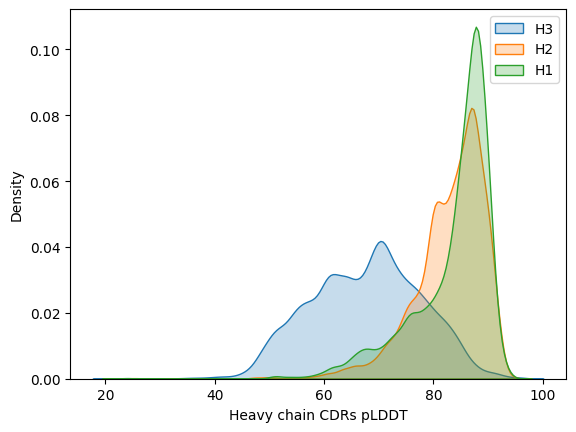

In [ ]:
sns.kdeplot(df_cdrs_reg[df_cdrs_reg['is_heavy']]['pLDDT_H3_before'], label='H3', fill=True)
sns.kdeplot(df_cdrs_reg[df_cdrs_reg['is_heavy']]['pLDDT_H2_before'], label='H2', fill=True)
sns.kdeplot(df_cdrs_reg[df_cdrs_reg['is_heavy']]['pLDDT_H1_before'], label='H1', fill=True)

plt.xlabel('Heavy chain CDRs pLDDT')
plt.legend()
plt.show()

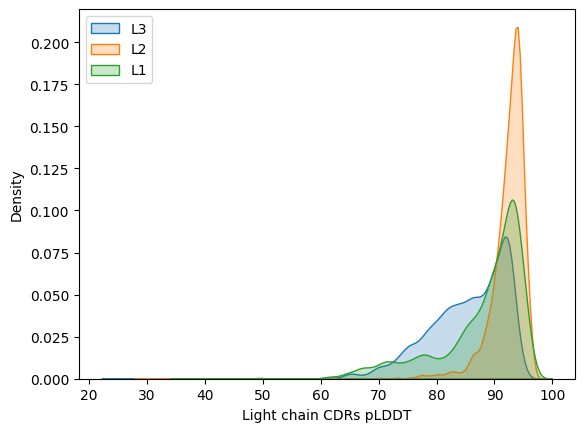

In [20]:
sns.kdeplot(df_cdrs_reg[~df_cdrs_reg['is_heavy']]['pLDDT_L3_before'], label='L3', fill=True)
sns.kdeplot(df_cdrs_reg[~df_cdrs_reg['is_heavy']]['pLDDT_L2_before'], label='L2', fill=True)
sns.kdeplot(df_cdrs_reg[~df_cdrs_reg['is_heavy']]['pLDDT_L1_before'], label='L1', fill=True)

plt.xlabel('Light chain CDRs pLDDT')
plt.legend()
plt.show()

In [16]:
df_cdrs_reg.shape[0]

32708

## H3 region extraction

In [11]:
H3_PATH = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_h3_region")

In [25]:
from proteinttt.utils.parsers import extract_h3_to_new_pdb
# Predicted files
for file in os.listdir(CDR_PATH):
    if file.endswith("ttt.pdb"):
        continue
    pdb = file.split("_")[0]
    chain = file.split("_")[1][0]
    if df_antigen.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0 or df_diff.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] != 0:
        # print(f"Skipping antigen chain {pdb}_{chain}")
        continue
    if (H3_PATH / file).exists():
        # print(f"H3 already extracted for {pdb}_{chain}, skipping.")
        continue
    
    try:
        is_heavy = is_chain_heavy(df_HLchain, pdb, chain)
    except Exception as e:
        print(f"Skipping {pdb}_{chain} due to error: {e}")
        continue
    # print(f"Extracting H3 for {pdb}_{chain}, is_heavy: {is_heavy}")
    extract_h3_to_new_pdb(
        CDR_PATH / file,
        H3_PATH / file,
        chain,
        is_heavy=is_heavy
    )
    

In [28]:
new_rows = []
num = 0
for file in os.listdir(H3_PATH):
    if file.endswith("ttt.pdb"):
        continue
    pdb: str = file.split("_")[0]
    chain = file.split("_")[1][0]
    
    if df_antigen.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0 or df_diff.query(f"pdb == '{pdb}' and chain == '{chain}'").shape[0] > 0:
        continue
    
    try:
        pLDDT_before = calculate_plddt(H3_PATH / f"{pdb}_{chain}_before_ttt.pdb")
        pLDDT_after = calculate_plddt(H3_PATH / f"{pdb}_{chain}_ttt.pdb")
    except Exception as e:
        # print(f"pLDDT extraction failed for {pdb}_{chain}: {e}.")
        pLDDT_before = None
        pLDDT_after = None
        
    try:
        lddt_before = lddt_score(pdb_ref=H3_PATH / f"{pdb}_{chain}.pdb", pdb_model=H3_PATH / f"{pdb}_{chain}_before_ttt.pdb")
        lddt_after = lddt_score(pdb_ref=H3_PATH / f"{pdb}_{chain}.pdb", pdb_model=H3_PATH / f"{pdb}_{chain}_ttt.pdb")
    except Exception as e:
        # print(f"lDDT calculation failed for {pdb}_{chain}: {e}.")
        lddt_before = None
        lddt_after = None
        
    try:
        tm_score_before = calculate_tm_score(pred_path=H3_PATH / f"{pdb}_{chain}_before_ttt.pdb", pdb_path=H3_PATH / f"{pdb}_{chain}.pdb")
        tm_score_after = calculate_tm_score(pred_path=H3_PATH / f"{pdb}_{chain}_ttt.pdb", pdb_path=H3_PATH / f"{pdb}_{chain}.pdb")
    except ValueError as e:
        # print(f"TMalign failed for {pdb}_{chain}: {e}.")
        tm_score_before = None
        tm_score_after = None
        
    new_rows.append({
        'pdb': pdb,
        'chain': chain,
        'pLDDT_before': pLDDT_before,
        'pLDDT_after': pLDDT_after,
        'tm_score_before': tm_score_before,
        'tm_score_after': tm_score_after,
        'lddt_before' : lddt_before,
        'lddt_after' : lddt_after
    })

df_cdrs = pd.DataFrame(new_rows)
df_cdrs.to_csv(base_path / Path("cdr_h3_evaluation.tsv"), sep="\t", index=False)

TMscore command:
['/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/TMalign', PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_h3_region/1oau_K_before_ttt.pdb'), PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_h3_region/1oau_K.pdb')]
TMscore output:

TMscore error:
Sequence is too short <3!: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_h3_region/1oau_K_before_ttt.pdb

TMscore command:
['/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/TMalign', PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_h3_region/5nml_J_before_ttt.pdb'), PosixPath('/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_h3_region/5nml_J.pdb')]
TMscore output:

TMscore error:
Sequence is too short <3!: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/cdr_h3_region/5nml_J_before_ttt.pdb



In [29]:
df_cdrs

,pdb,chain,pLDDT_before,pLDDT_after,tm_score_before,tm_score_after,lddt_before,lddt_after
0,4hg4,P,51.03,52.42,0.30843,0.31807,0.735669,0.703346
1,7ty0,J,70.33,74.69,0.21962,0.37281,0.678571,0.669643
2,7pa8,L,66.34,59.91,0.34332,0.37797,0.847222,0.784722
3,7s1b,X,51.91,57.95,0.28891,0.33764,0.781313,0.863889
4,7pr0,G,43.94,43.27,0.15162,0.17514,0.393752,0.519592
...,...,...,...,...,...,...,...,...
171,6e8v,O,50.34,51.92,0.19937,0.18997,0.571652,0.511180
172,6de7,D,49.10,52.11,0.20684,0.14878,0.600581,0.573916
173,6e8v,U,35.66,41.79,0.25777,0.32584,0.387715,0.525059
174,4m1c,C,45.93,51.48,0.15160,0.18443,0.650605,0.628351


# Antigens

## Calculate pLDDT, tmscore and LDDT

In [ ]:
df_eval_antegen = calculate_all_metrics(df_antigen)
df_eval_antegen.to_csv(base_path / Path("antigen_evaluation.tsv"), sep="\t", index=False)

# HLchains

In [ ]:
df_eval_HLchain = calculate_all_metrics(df_HLchain)
df_eval_HLchain.to_csv(base_path / Path("HLchain_evaluation.tsv"), sep="\t", index=False)

,pdb,chain,pLDDT_before,pLDDT_after,tm_score_before,tm_score_after,lddt_before,lddt_after
0,9mq8,L,72.81,75.86,0.33283,0.32491,0.670348,0.646164
1,9mgb,A,43.88,46.33,0.32087,0.38574,0.473906,0.534656
2,9mgb,C,43.88,77.79,0.32087,0.65812,0.472989,0.833624
3,9mgb,G,70.18,76.67,0.61381,0.62308,0.777972,0.737604
4,9mgb,I,43.88,78.29,0.32087,0.67230,0.474939,0.842242
...,...,...,...,...,...,...,...,...
283,7kra,I,50.69,NaN,0.33776,NaN,0.396568,NaN
284,7c80,H,74.13,80.24,0.32465,0.32804,0.491986,0.420365
285,3rif,J,71.15,80.14,0.38890,0.36909,0.706488,0.777537
286,6e9g,A,70.94,72.83,0.67966,0.60805,0.759611,0.750660


# Plots

In [89]:
df_cdrs = pd.read_csv(base_path / Path("antigen_evaluation.tsv"), sep="\t", low_memory=False)

In [91]:
import plotly.express as px
subdf = df_cdrs.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(len(subdf))

diff = subdf['tm_score_after'] - subdf['tm_score_before']

fig = px.box(y=diff, points='all')  
fig.update_traces(
    pointpos=0,
    jitter=0.35,                    
    marker_color='green',
    marker_opacity=0.5,
    marker_size=5,
    fillcolor='rgba(173,216,230,0.45)', 
    line_color='rgba(173,216,230,1)'
)
fig.update_layout(
    title_text='TM-score difference after and before ProteinTTT for antigen chains',
)
fig.show()

932


In [92]:
diff[diff < -0.05].shape[0] / diff.shape[0], diff[(diff > -0.05) & (diff < 0.005)].shape[0] / diff.shape[0], diff[diff > 0.005].shape[0] / diff.shape[0]

(0.11266094420600858, 0.4560085836909871, 0.4281115879828326)

In [11]:
df_cdrs['tm_score_difference'] = df_cdrs['tm_score_after'] - df_cdrs['tm_score_before']

top_5_tm_diff = df_cdrs.nlargest(5, 'tm_score_difference')
top_5_tm_diff

,pdb,chain,pLDDT_before,pLDDT_after,tm_score_before,tm_score_after,lddt_before,lddt_after,tm_score_difference
100,7o85,Q,44.52,75.12,0.16066,0.58434,0.348736,0.824981,0.42368
138,7ty0,K,60.84,64.23,0.26703,0.50662,0.689134,0.782810,0.23959
69,9mgb,I,41.01,81.29,0.27828,0.50321,0.695996,0.905440,0.22493
95,9mgb,C,41.01,80.72,0.28063,0.49186,0.704676,0.903741,0.21123
43,2j88,H,80.51,86.53,0.56330,0.73610,0.931323,0.971848,0.17280


222


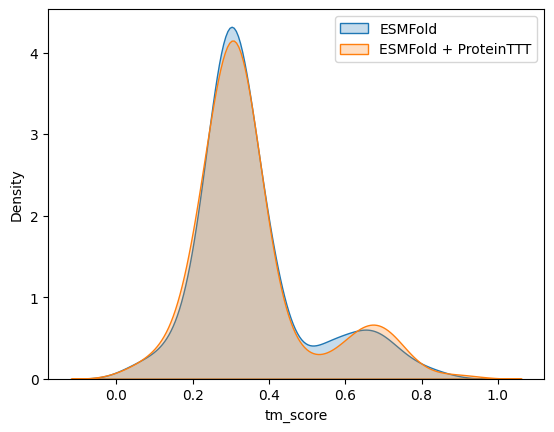

In [70]:
subdf = df_cdrs.query("tm_score_before.notna() and tm_score_after.notna()")
print(len(subdf))

sns.kdeplot(subdf['tm_score_before'], label='ESMFold', fill=True)
sns.kdeplot(subdf['tm_score_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('tm_score')
plt.legend()
plt.show()

In [36]:
subdf.tm_score_before.describe(), subdf.tm_score_after.describe()

(count    174.000000
 mean       0.276777
 std        0.139796
 min        0.107250
 25%        0.199797
 50%        0.237820
 75%        0.305690
 max        0.986120
 Name: tm_score_before, dtype: float64,
 count    174.000000
 mean       0.285304
 std        0.147378
 min        0.087780
 25%        0.194350
 50%        0.242720
 75%        0.328157
 max        0.968470
 Name: tm_score_after, dtype: float64)

In [1]:
subdf.lddt_before.describe(), subdf.lddt_after.describe()

NameError: name 'subdf' is not defined

In [38]:
subdf.pLDDT_before.describe(), subdf.pLDDT_after.describe()

(count    174.000000
 mean      48.371782
 std       13.235608
 min       21.930000
 25%       38.640000
 50%       50.430000
 75%       57.535000
 max       85.380000
 Name: pLDDT_before, dtype: float64,
 count    174.000000
 mean      54.200747
 std       13.130923
 min       24.660000
 25%       46.970000
 50%       54.460000
 75%       64.037500
 max       87.720000
 Name: pLDDT_after, dtype: float64)

175


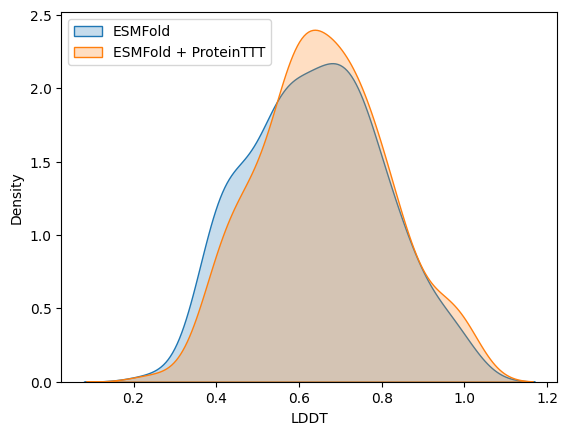

In [33]:
subdf = df_cdrs.query("lddt_before.notna() and lddt_after.notna()")
print(len(subdf))

sns.kdeplot(subdf['lddt_before'], label='ESMFold', fill=True)
sns.kdeplot(subdf['lddt_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('LDDT')
plt.legend()
plt.show()

221


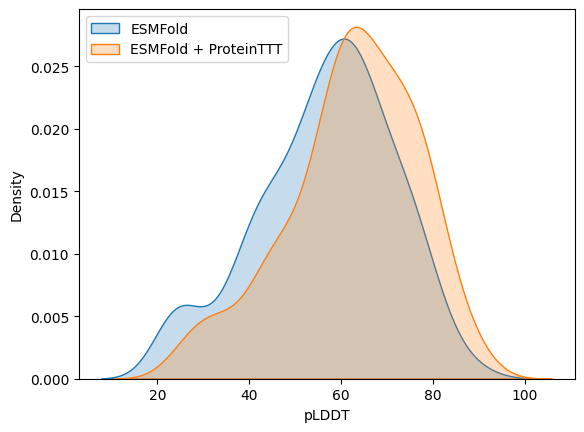

In [64]:
subdf = df_cdrs.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(len(subdf))

sns.kdeplot(subdf['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(subdf['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

(0.1095890410958904, 0.3926940639269406, 0.4977168949771689)

In [40]:
t = pd.read_csv(filepath_or_buffer=Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/notebooks/summary_metrics.csv"))
t

,Unnamed: 0,Antigen_chains,HLchains,CDR,H3
0,TM_score_min_before,0.026600,0.042940,0.114220,0.107250
1,TM_score_median_before,0.325050,0.310245,0.335610,0.237820
2,TM_score_max_before,0.900530,0.843080,0.824570,0.986120
3,TM_score_min_after,0.029990,0.035770,0.062980,0.087780
4,TM_score_median_after,0.333930,0.312520,0.366910,0.242720
5,TM_score_max_after,0.922660,0.906910,0.850560,0.968470
6,LDDT_min_before,0.196656,0.228827,0.271506,0.364248
7,LDDT_median_before,0.394904,0.659870,0.596133,0.650060
8,LDDT_max_before,0.977778,0.823265,0.997059,1.000000
9,LDDT_min_after,0.196530,0.154677,0.290674,0.375220
